# **Feature Engineering**

## Objectives

* Engineer features for classification and cluster models

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Generate a list of variables to engineer


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

# Load Cleaned Data

Train Set

In [ ]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head()

Test Set

In [ ]:
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head()

---

# Data Exploration

Running generating `ProfileReport` on the test set to investigate potential transformations that may be made

In [ ]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

# Correlation and PPS Analysis

No expected change compared to data cleaning notebook, only difference being the removal of the `veil-type` and `stalk-root` columns.

# Feature Engineering

## Custom Function

Will use altered form of the custom function from the feature engineering lesson, as there is no available numerical feature engineering for this project and the only feature engineering will be done via categorical encoders. Three encoders will be compared, `OneHotEncoder`, `OrdinalEncoder`, and `TargetEncoder`.

In [18]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine.encoding import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['target_encoder', 'ordinal_encoder', 'one_hot_encoder']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        if column == 'class':
            continue
        else:
            # create additional columns (column_method) to apply the methods
            df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
            for method in list_column_transformers:
                df_feat_eng[f"{column}_{method}"] = df[column]

            # Apply transformers in respective column_transformers
            df_feat_eng, list_applied_transformers = apply_transformers(
                analysis_type, df_feat_eng, column, df['class'])
            # For each variable, assess how the transformations perform
            transformer_evaluation(
                column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'target_encoder':
        list_column_transformers = ["target_encoder"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'one_hot_encoder':
        list_column_transformers = ['one_hot_encoder']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column, target):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'target_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_TargetEncoder(
            df_feat_eng, column, target)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_OrdinalEncoder(
            df_feat_eng, column)

    elif analysis_type == 'one_hot_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_OneHotEncoder(
            df_feat_eng, column)
    
    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:
        if col == column:
            DiagnosticPlots_Categories(df_feat_eng, col)
        else:
            if analysis_type == "one_hot_encoder":
                for sub_col in [i for i in list(df_feat_eng.drop([column], axis=1).columns) if "one_hot_encoder" in i and column in i]:
                    DiagnosticPlots_Numerical(df_feat_eng, sub_col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_TargetEncoder(df_feat_eng, column, target):
    list_methods_worked = []
    # Target encoder
    try:
        encoder = TargetEncoder()
        df_feat_eng[f"{column}_target_encoder"] = encoder.fit_transform(df_feat_eng[f"{column}_target_encoder"].to_frame(), target)
        list_methods_worked.append(f"{column}_target_encoder")
    except Exception:
        df_feat_eng.drop([f"{column}_target_encoder"], axis=1, inplace=True)
    return df_feat_eng, list_methods_worked


def FeatEngineering_OrdinalEncoder(df_feat_eng, column):
    list_methods_worked = []
    # Ordinal encoder
    try:
        encoder = OrdinalEncoder(categories=[list(df_feat_eng[column].unique())])
        df_feat_eng[f"{column}_ordinal_encoder"] = encoder.fit_transform(df_feat_eng[f"{column}_ordinal_encoder"].to_frame())
        list_methods_worked.append(f"{column}_ordinal_encoder")
    except Exception as e:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)
        print(str(e))
    return df_feat_eng, list_methods_worked


def FeatEngineering_OneHotEncoder(df_feat_eng, column):
    list_methods_worked = []
    # OneHotEncoder
    try:
        encoder = OneHotEncoder(variables=[f"{column}_one_hot_encoder"], drop_last=False)
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_one_hot_encoder")
    except Exception:
        df_feat_eng.drop([f"{column}_one_hot_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

### Dealing with Feature Engineering

#### Categorical Encoding - Ordinal Encoding

Select variables 

In [ ]:
variables_engineering = list(TrainSet.columns)
variables_engineering

Create separate dataframe to store variables

In [ ]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

Create engineered variables by applying the transformations, assess variable distribution and select the most suitable method for each variable.

In [ ]:
%matplotlib inline
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

As discussed previously in the `Edibility Study` notebook, a downside to the use of ordinal encoders is that categories are arbitrarily ordered. For a variable with three or less possible categories, this is unimportant, as the swapped numerical ordering of different categories won't have an outsized effect on said number's correlation to the target variable, only whether the variable has a negative or positive correlation to the target (which is physically meaningless for categorical variables). However, in the case of categorical variables with more categories than three (e.g. the `odor` variable, which has 9 distinct categories), ordering becomes relevant, and has an outsized effect on an encoded variables correlation to the target. This will adversely effect the performance of any model created using the data in an arbitrary fashion. As there is no sensible ordering for any of the variables, this encoding will not be used.

#### Categorical Encoding - One Hot Encoder

Create separate dataframe to store variables

In [ ]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

Create engineered variables by applying the transformations, assess variable distribution and select the most suitable method for each variable. (Warning - this code cell produces a huge output, may take upwards of a minute to run).

In [ ]:
%matplotlib inline
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='one_hot_encoder')

As can be seen from the above output, `OneHotEncoder` applied to this dataset generates a massive number of variables, some of them being entirely skewed due to the rare occurence/common occurence of certain categories compared to others. It is unlikely this encoder will produce well-performing models, as many of the variables effectively have one unique value, and for those that have a better distribution there are too many variables, producing a situation of ['Curse of Dimensionality'](https://en.wikipedia.org/wiki/Curse_of_dimensionality), where there are so many variables that model performance deteriorates rather than improves. As such this encoder is not appropriate.

#### Categorical Encoding - Target Encoder

Create separate dataframe to store variables

In [19]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,k,s,g,f,n,f,w,b,p,...,s,s,w,w,w,t,p,w,s,g
1,1,x,f,w,f,n,f,w,b,g,...,s,s,w,w,w,t,p,w,n,g
2,1,x,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,k,s,m
3,1,f,s,w,f,n,f,w,b,h,...,s,f,w,w,w,o,e,k,s,g
4,0,k,y,e,f,y,f,c,n,b,...,s,k,w,p,w,o,e,w,v,l


Create engineered variables by applying the transformations, assess variable distribution and select the most suitable method for each variable.

* Variable Analyzed: cap-shape
* Applied transformation: ['cap-shape_target_encoder'] 



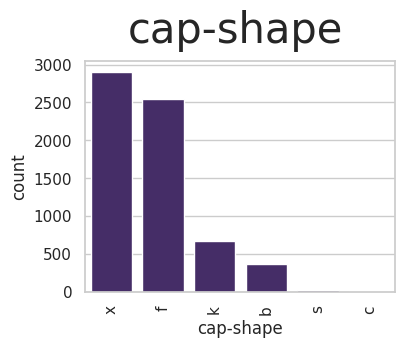

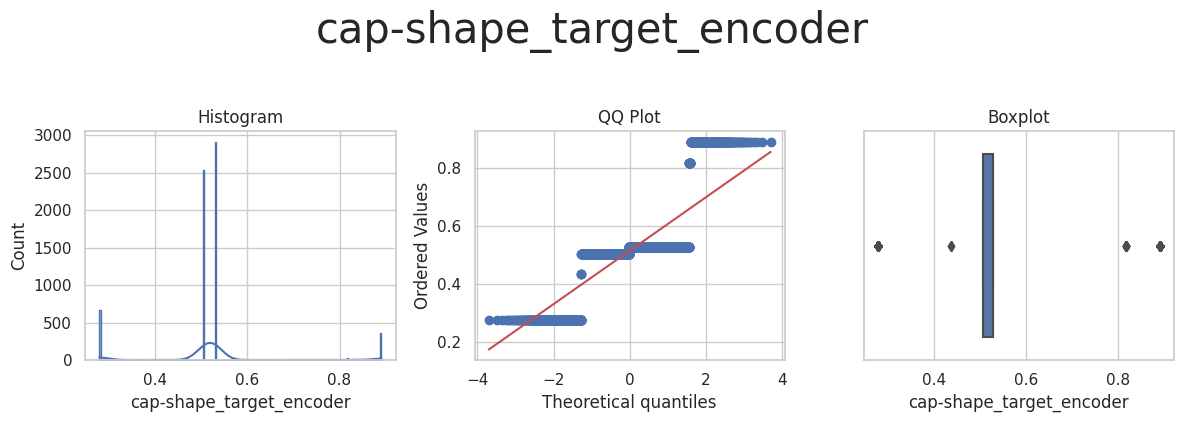



* Variable Analyzed: cap-surface
* Applied transformation: ['cap-surface_target_encoder'] 



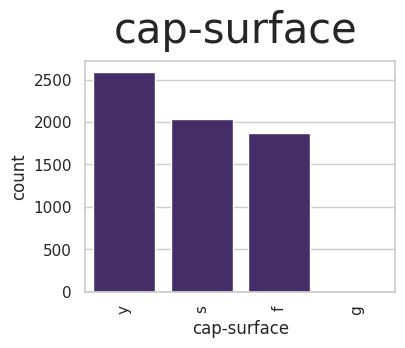

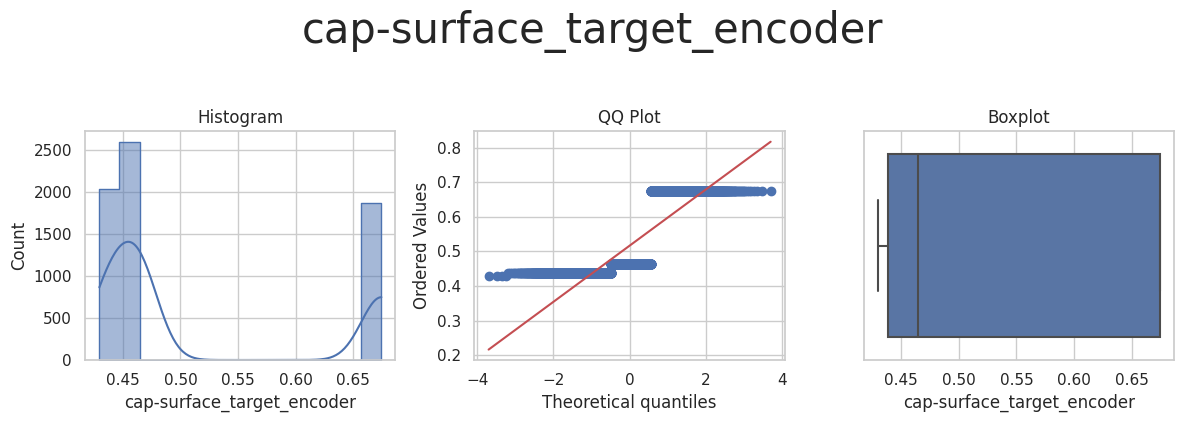



* Variable Analyzed: cap-color
* Applied transformation: ['cap-color_target_encoder'] 



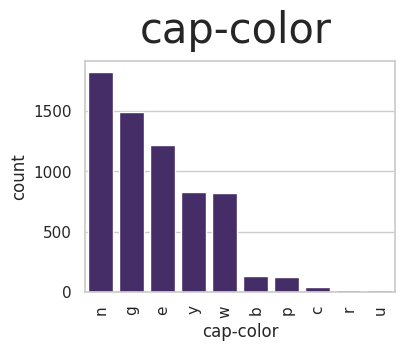

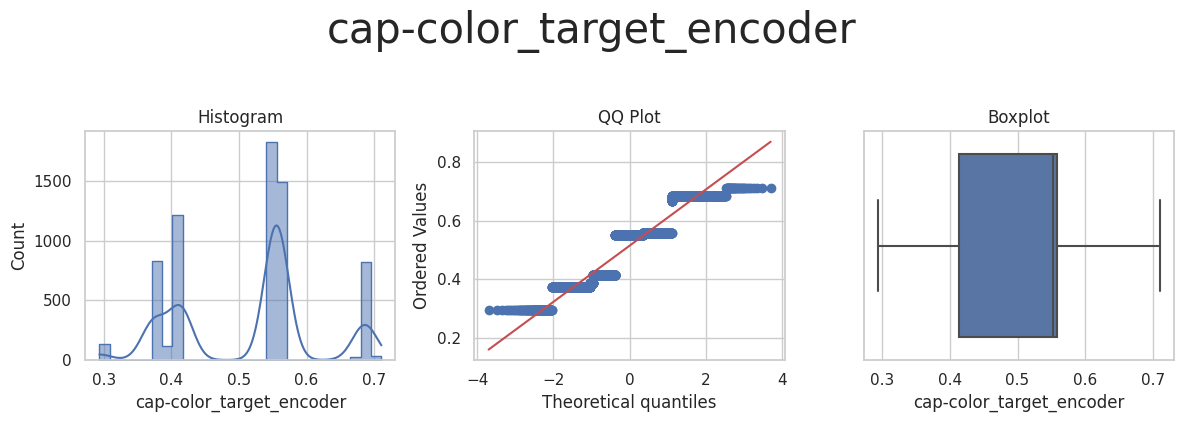



* Variable Analyzed: bruises
* Applied transformation: ['bruises_target_encoder'] 



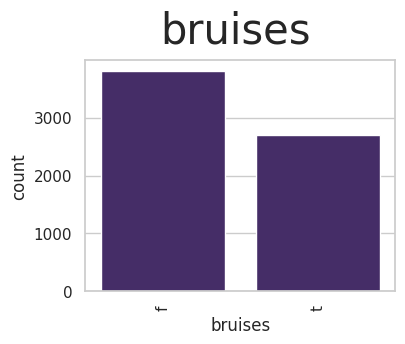

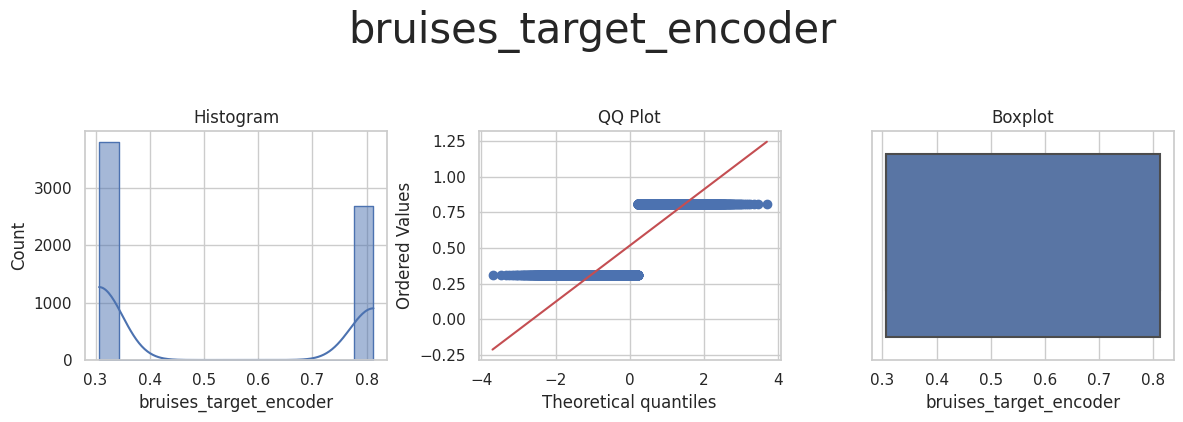



* Variable Analyzed: odor
* Applied transformation: ['odor_target_encoder'] 



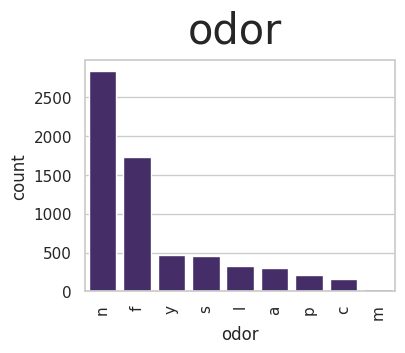

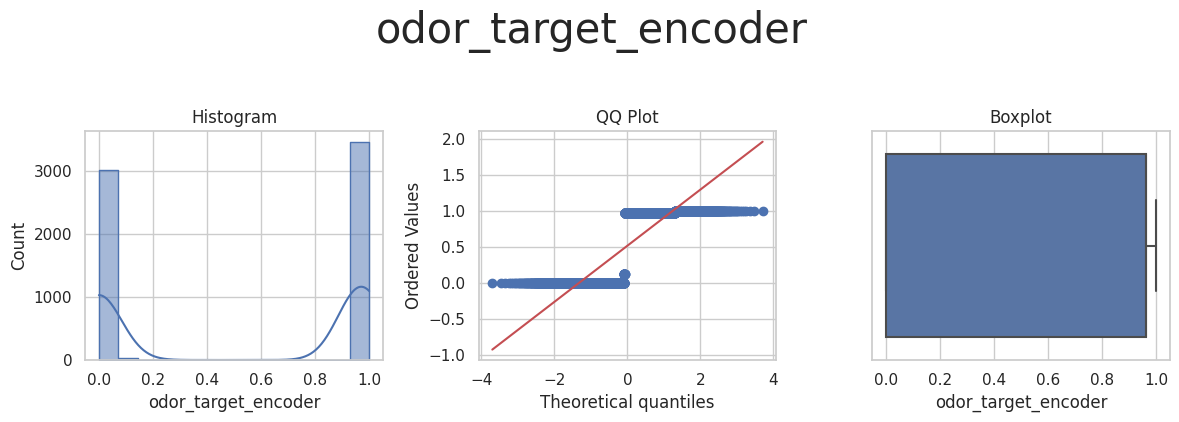



* Variable Analyzed: gill-attachment
* Applied transformation: ['gill-attachment_target_encoder'] 



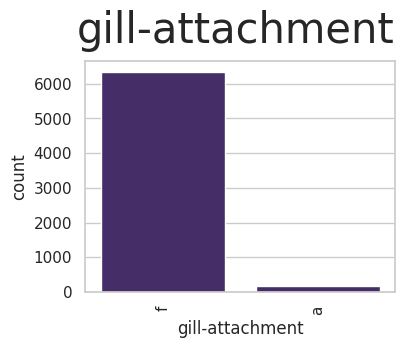

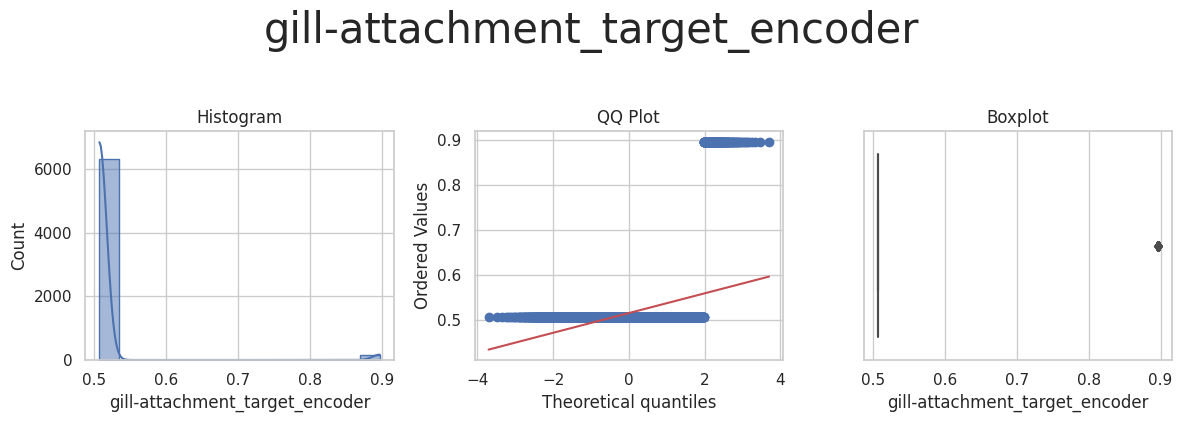



* Variable Analyzed: gill-spacing
* Applied transformation: ['gill-spacing_target_encoder'] 



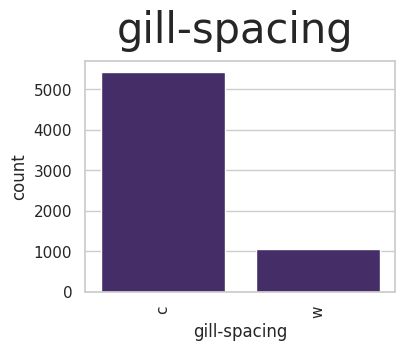

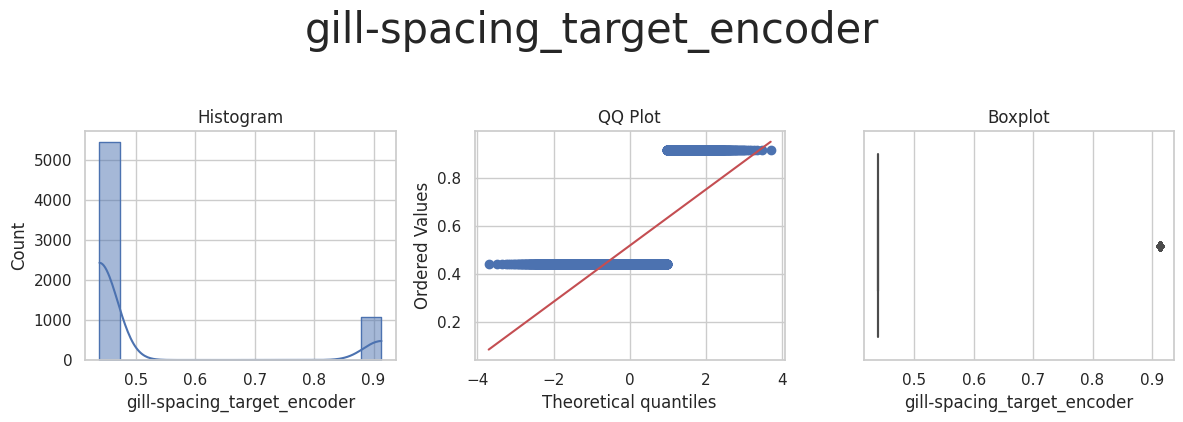



* Variable Analyzed: gill-size
* Applied transformation: ['gill-size_target_encoder'] 



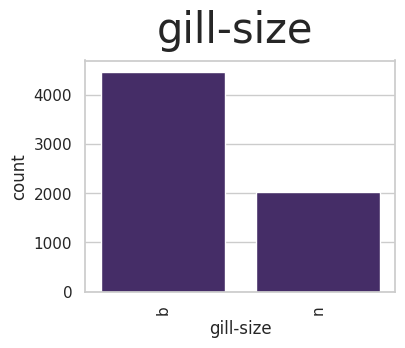

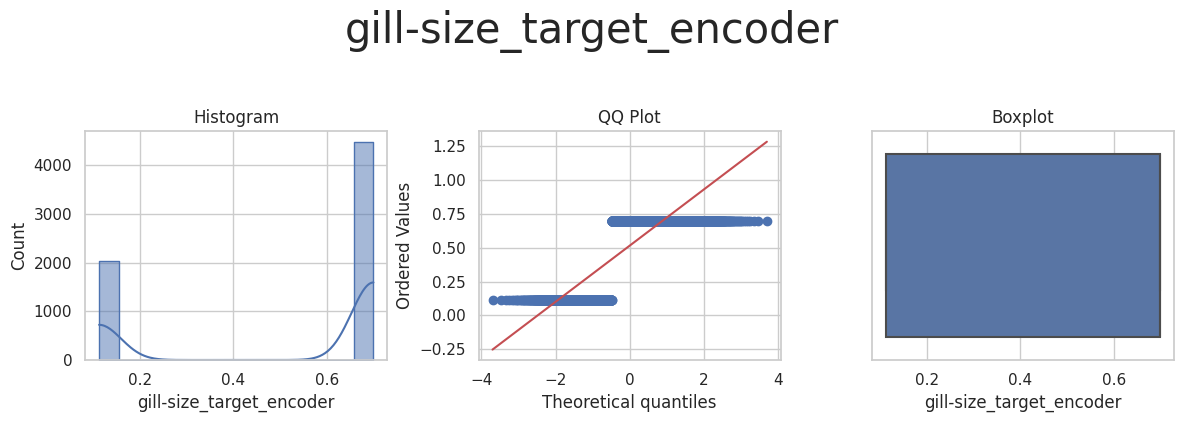



* Variable Analyzed: gill-color
* Applied transformation: ['gill-color_target_encoder'] 



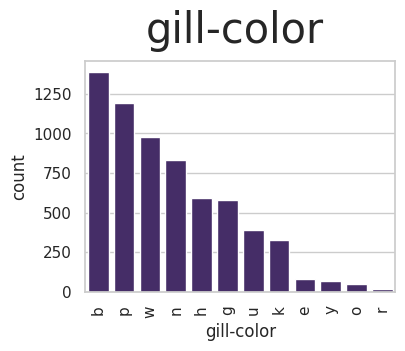

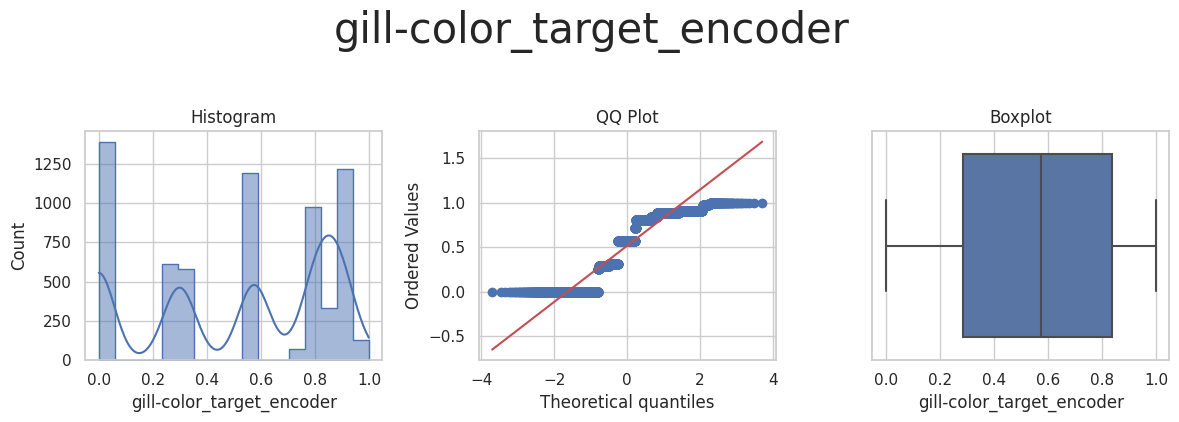



* Variable Analyzed: stalk-shape
* Applied transformation: ['stalk-shape_target_encoder'] 



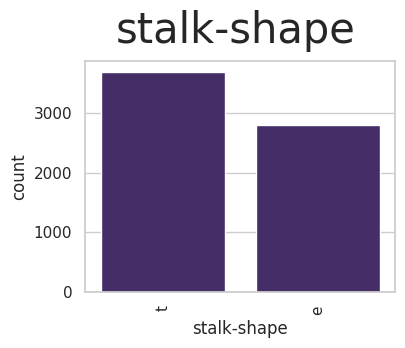

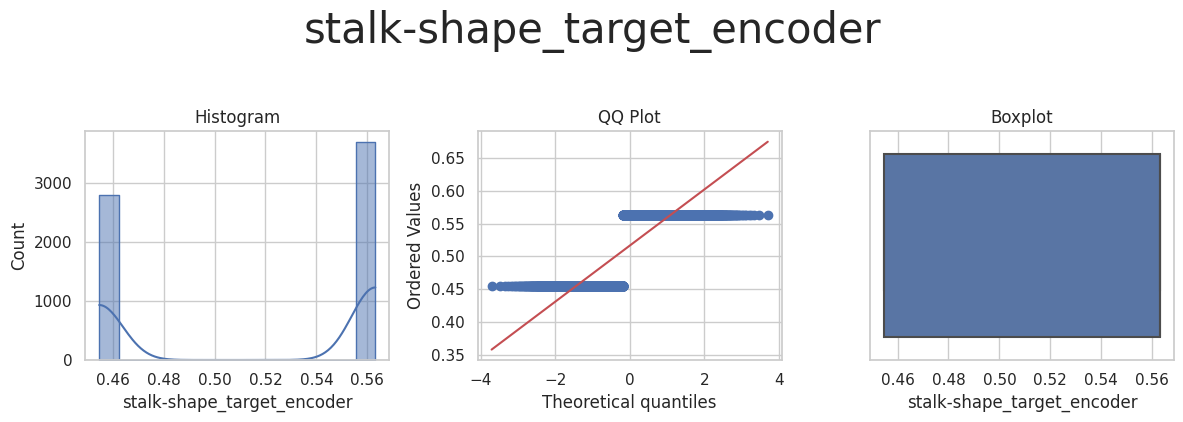



* Variable Analyzed: stalk-surface-above-ring
* Applied transformation: ['stalk-surface-above-ring_target_encoder'] 



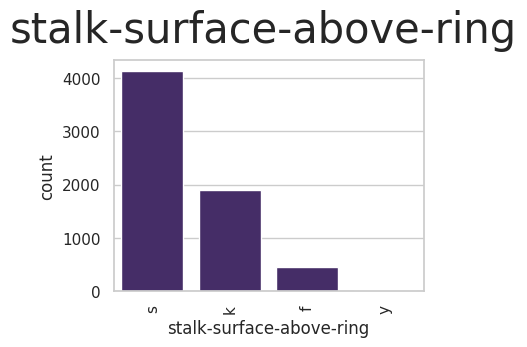

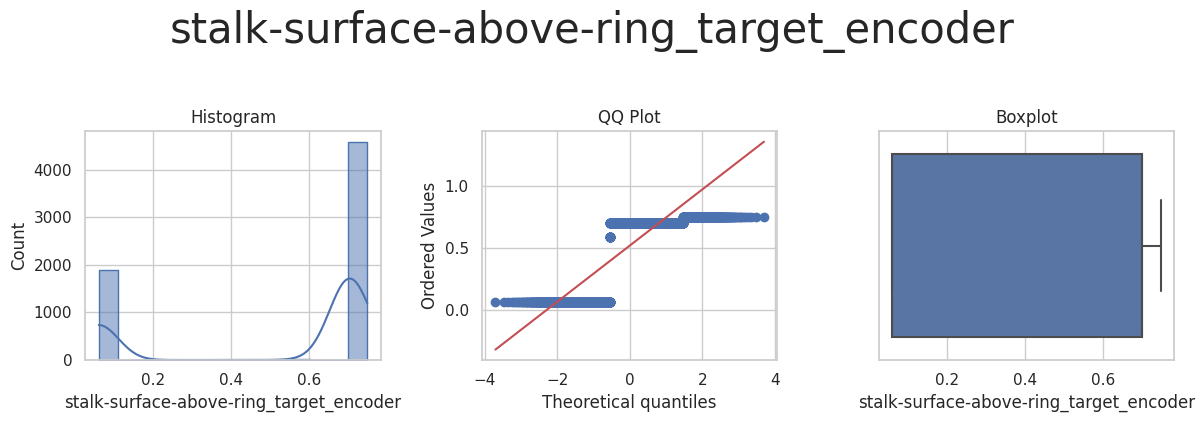



* Variable Analyzed: stalk-surface-below-ring
* Applied transformation: ['stalk-surface-below-ring_target_encoder'] 



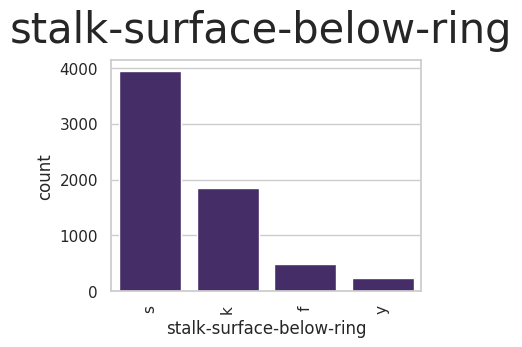

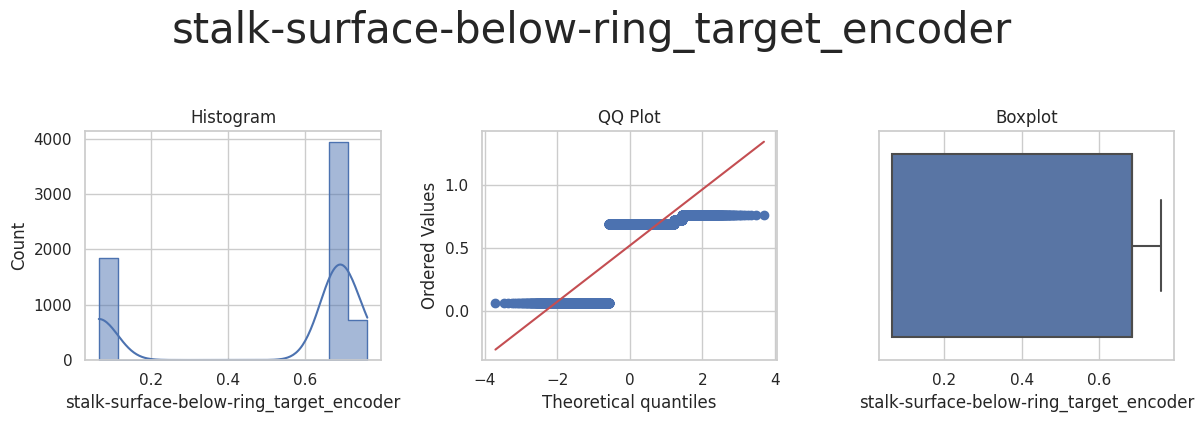



* Variable Analyzed: stalk-color-above-ring
* Applied transformation: ['stalk-color-above-ring_target_encoder'] 



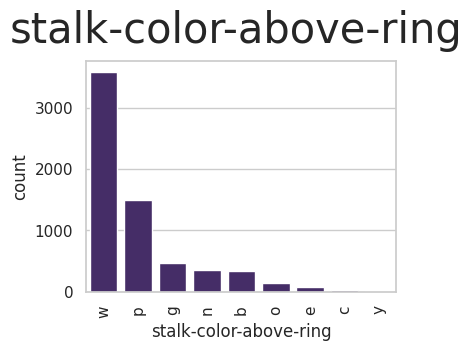

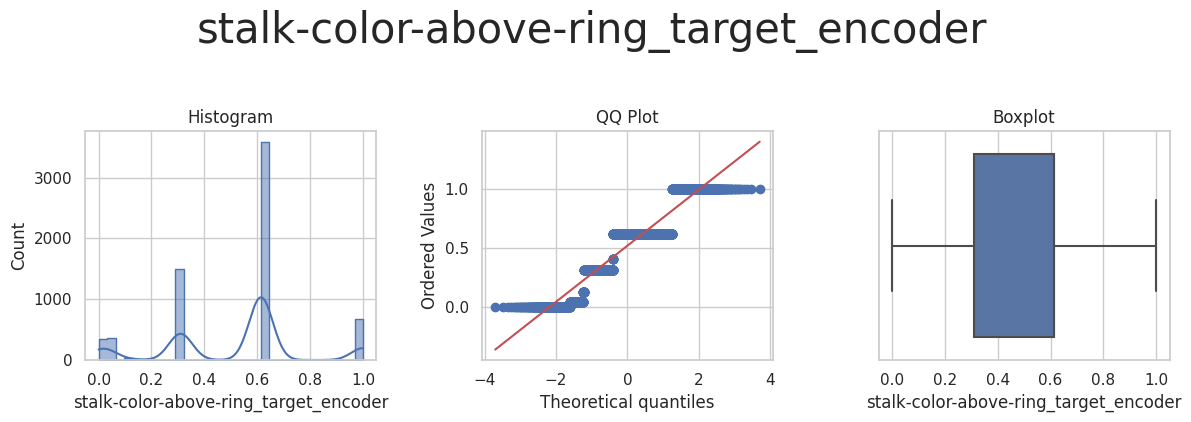



* Variable Analyzed: stalk-color-below-ring
* Applied transformation: ['stalk-color-below-ring_target_encoder'] 



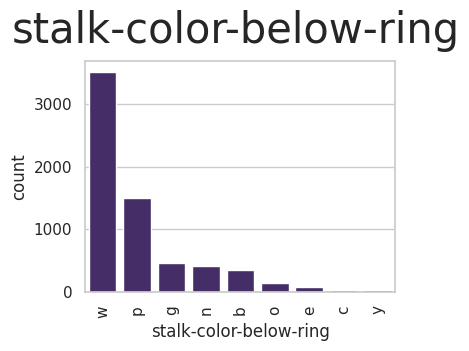

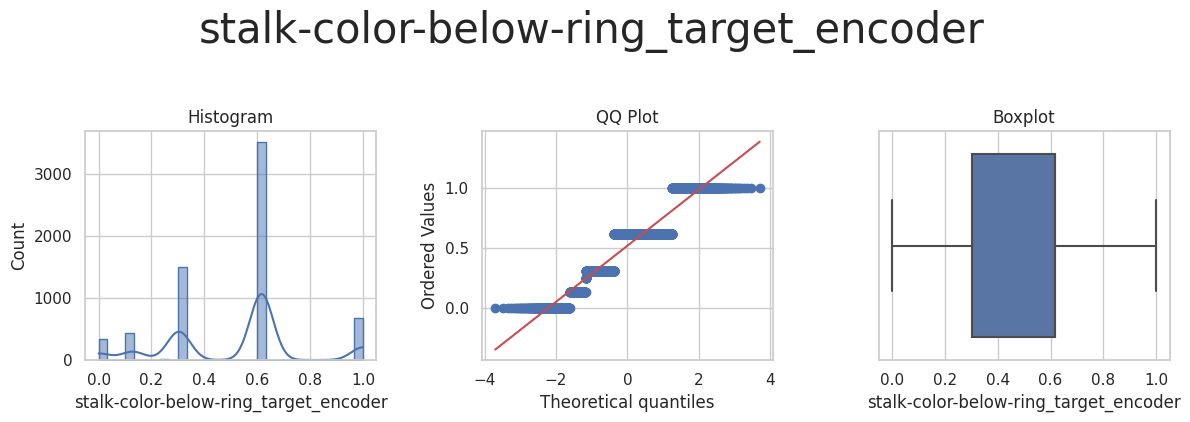



* Variable Analyzed: veil-color
* Applied transformation: ['veil-color_target_encoder'] 



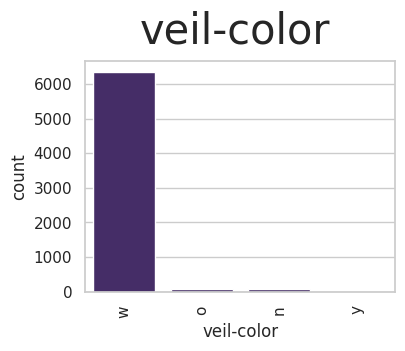

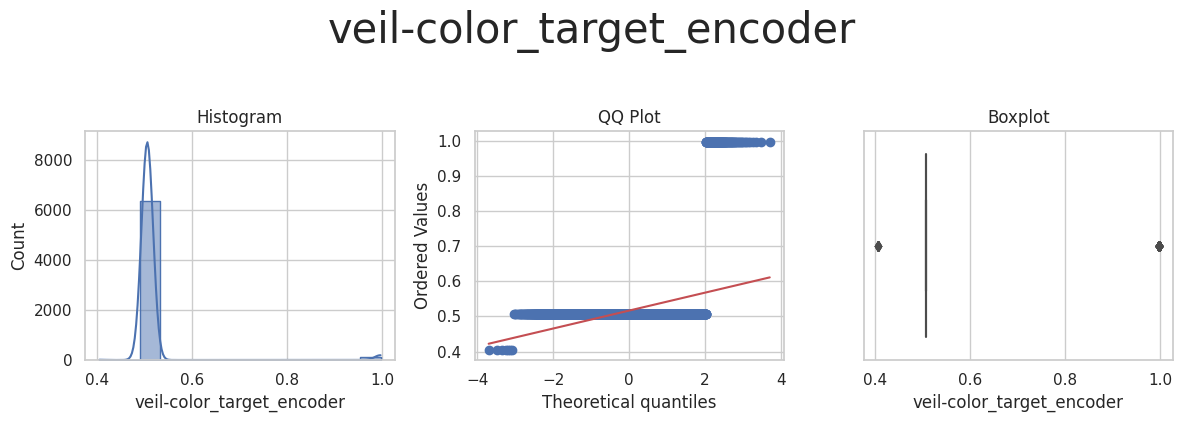



* Variable Analyzed: ring-number
* Applied transformation: ['ring-number_target_encoder'] 



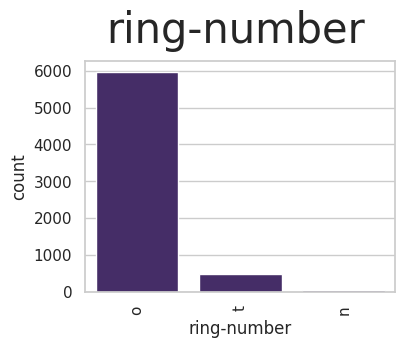

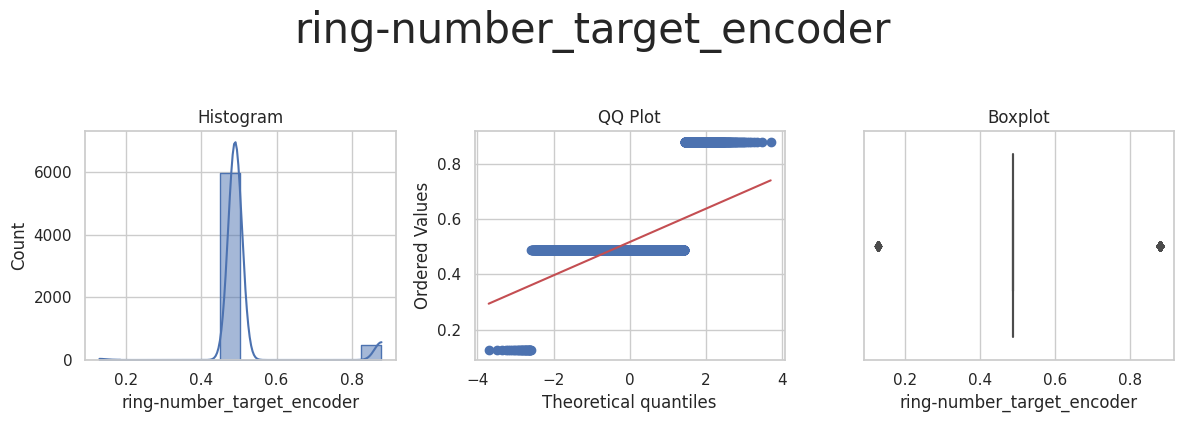



* Variable Analyzed: ring-type
* Applied transformation: ['ring-type_target_encoder'] 



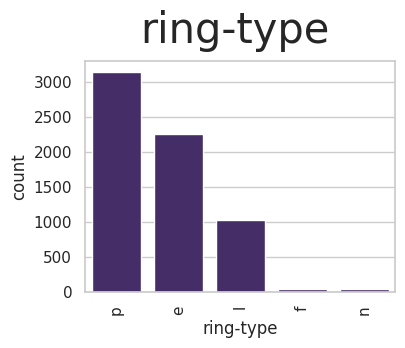

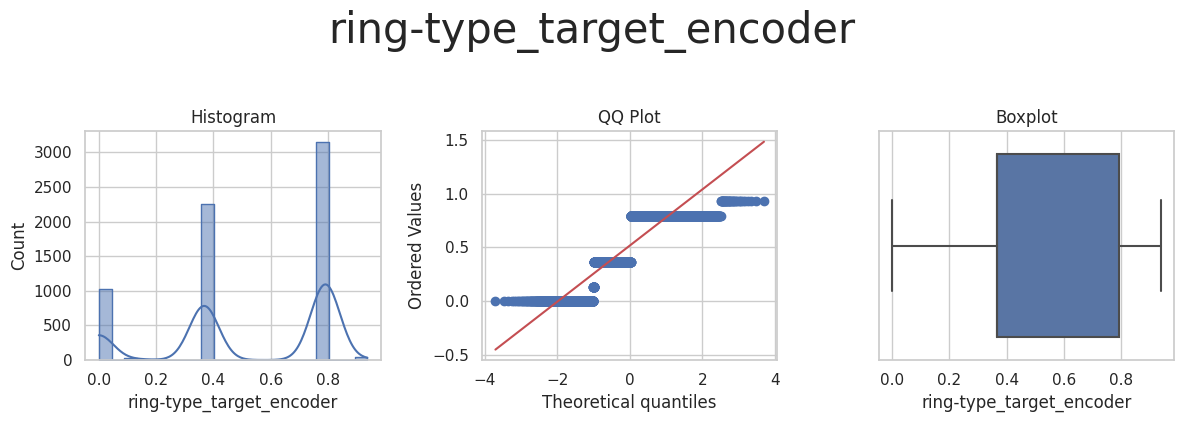



* Variable Analyzed: spore-print-color
* Applied transformation: ['spore-print-color_target_encoder'] 



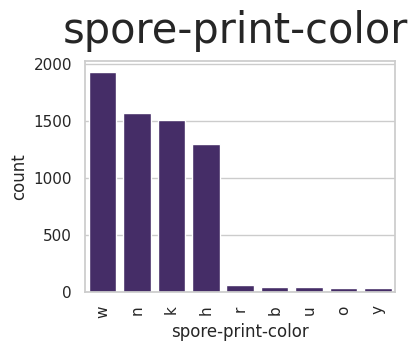

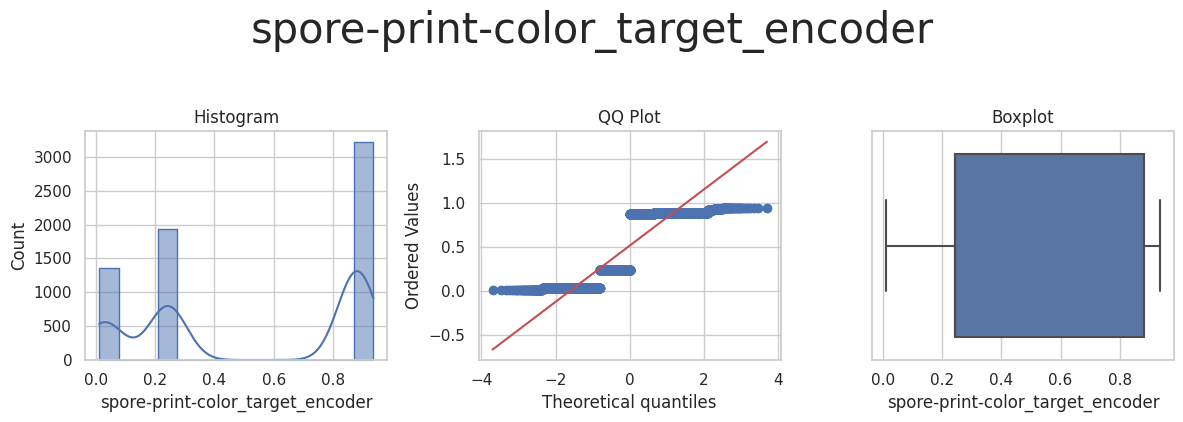



* Variable Analyzed: population
* Applied transformation: ['population_target_encoder'] 



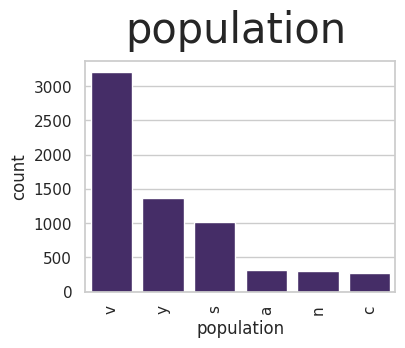

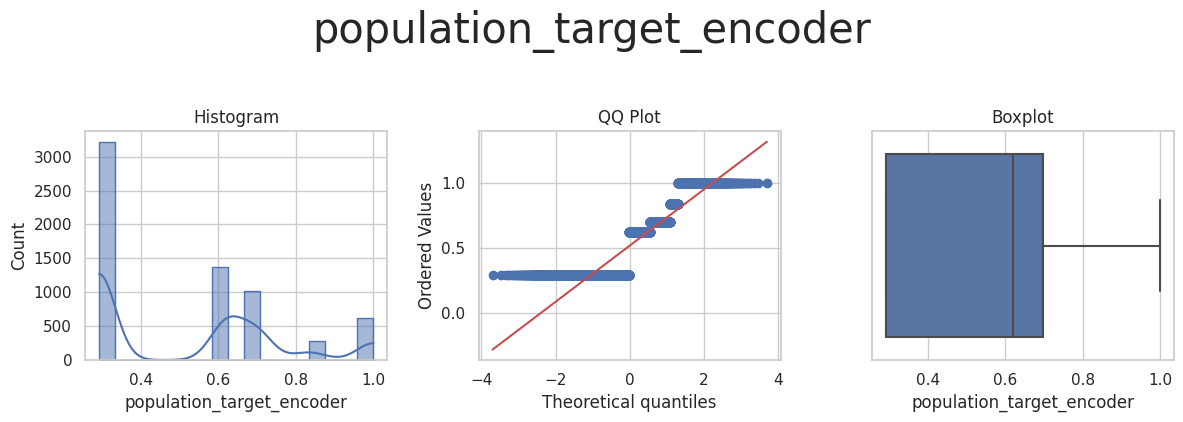



* Variable Analyzed: habitat
* Applied transformation: ['habitat_target_encoder'] 



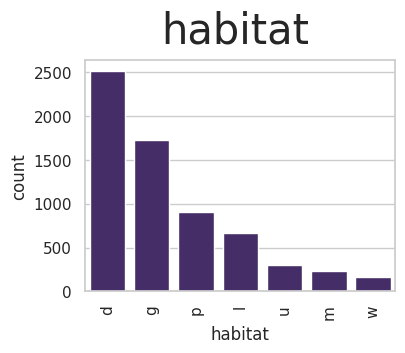

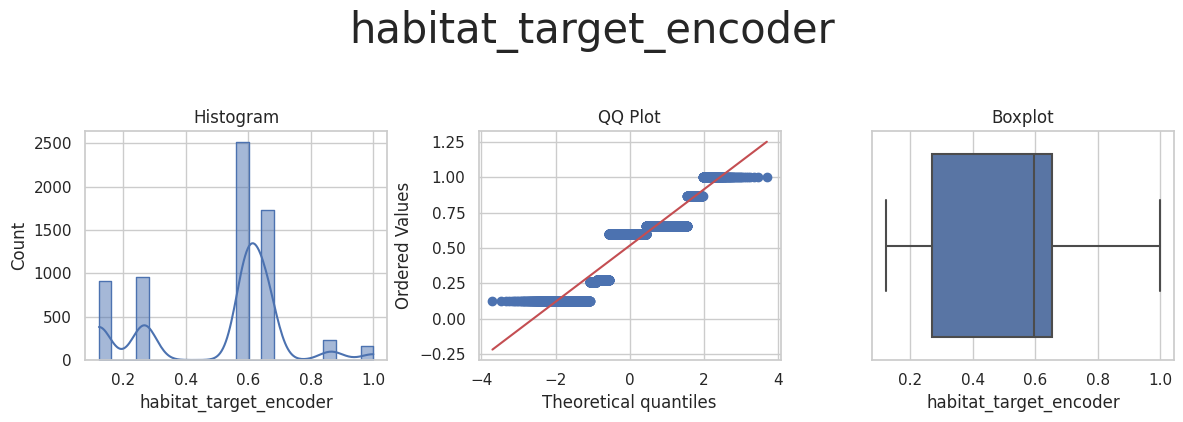

In [20]:
%matplotlib inline
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='target_encoder')

As can be seen in the above output, the encoder succesfully transforms the variables into numerical values, which in most cases appear to have good distributions per their histograms, QQ plots, and boxplots. This encoding method neither has the disadvantage of arbitrary numerical ordering as with ordinal encoding nor the Curse of Dimensionality as with one hot encoding.
* For all variables, target encoding will be used, with the target being taken from the TrainSet

Apply the selected transformation to the Train and Test set

In [21]:
encoder = TargetEncoder()
TrainSet = encoder.fit_transform(TrainSet, TrainSet['class'])
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - target transformation done!")

* Categorical encoding - target transformation done!


### SmartCorrelatedSelection Variables

Create separate DataFrame with variables.

In [24]:
df_engineering = TrainSet.copy()
df_engineering.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,0.279035,0.438147,0.558981,0.306519,0.964374,0.507093,0.913289,0.699396,0.573826,...,0.700097,0.685533,0.613947,0.616084,0.506375,0.87885,0.790661,0.242361,0.698318,0.655093
1,1,0.529735,0.674506,0.686203,0.306519,0.964374,0.507093,0.913289,0.699396,0.314433,...,0.700097,0.685533,0.613947,0.616084,0.506375,0.87885,0.790661,0.242361,1.000000,0.655093
2,1,0.529735,0.438147,0.686203,0.812616,1.000000,0.507093,0.438948,0.699396,0.885954,...,0.700097,0.685533,0.613947,0.616084,0.506375,0.48955,0.790661,0.878486,0.698318,0.865217
3,1,0.506100,0.438147,0.686203,0.306519,0.964374,0.507093,0.913289,0.699396,0.284512,...,0.700097,0.760331,0.613947,0.616084,0.506375,0.48955,0.367673,0.878486,0.698318,0.655093
4,0,0.279035,0.464355,0.413793,0.306519,0.000000,0.507093,0.438948,0.112919,0.000000,...,0.700097,0.064096,0.613947,0.304203,0.506375,0.48955,0.367673,0.242361,0.292561,0.269985


Create engineered variables applying the transformation.

In [25]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'class', 'gill-color', 'odor', 'spore-print-color'},
 {'bruises', 'ring-type'},
 {'gill-attachment', 'veil-color'},
 {'stalk-surface-above-ring', 'stalk-surface-below-ring'}]

In [30]:
corr_sel.features_to_drop_

['bruises',
 'odor',
 'gill-attachment',
 'gill-color',
 'stalk-surface-below-ring',
 'spore-print-color']

---

# Conclusion

Will add the following transformations to the ML Pipeline for feature engineering:

* Target categorical encoding: `['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']` with respect to `class` as the target
* Smart Correlation Selection: `['bruises', 'odor', 'gill-attachment', 'gill-color', 'stalk-surface-below-ring', 'spore-print-color']`